In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/oc-atsp/nao.csv')

# Parse the date
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Set the date as the index
df.set_index('date', inplace=True)

# Interpolate missing values
df['nao_index_cdas'].interpolate(method='linear', inplace=True)
df

/tmp/ipykernel_34/1352292371.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['nao_index_cdas'].interpolate(method='linear', inplace=True)


,year,month,day,nao_index_cdas
date,,,,
1950-01-01,1950,1,1,0.365000
1950-01-02,1950,1,2,0.096000
1950-01-03,1950,1,3,-0.416000
1950-01-04,1950,1,4,-0.616000
1950-01-05,1950,1,5,-0.261000
...,...,...,...,...
2024-05-08,2024,5,8,0.246422
2024-05-09,2024,5,9,0.475453
2024-05-10,2024,5,10,0.656409


In [3]:
# Split the data into training and validation sets
train = df[(df.index >= '1950-01-01') & (df.index <= '2024-01-01')]
validation = df[(df.index >= '2024-01-01') & (df.index <= '2024-05-12')]

# Define parameters
past_points = 60
future_points = 5

# ARIMA

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 0.22527320956912145


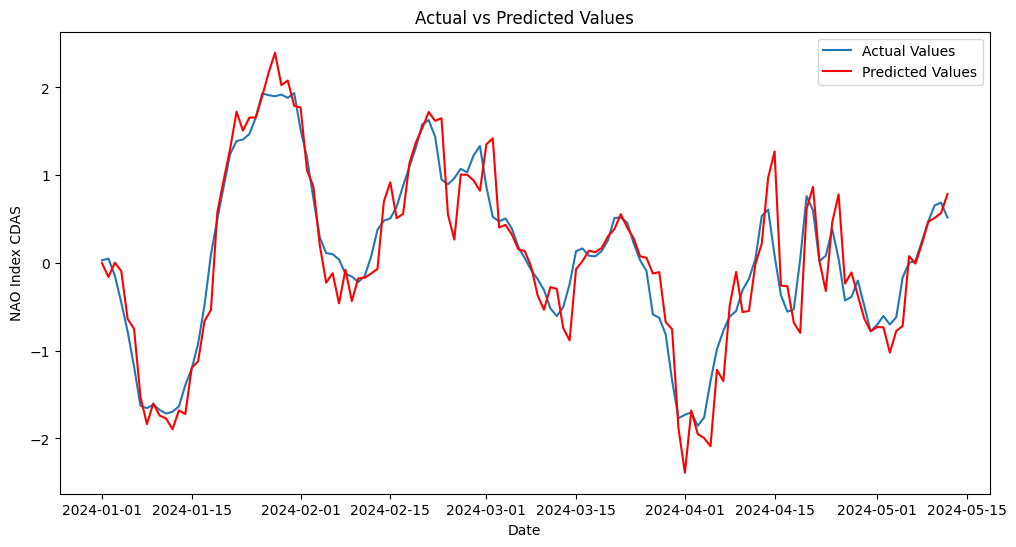

In [79]:
predictions = []
history = train['nao_index_cdas'].tolist()

for i in range(0, len(validation), future_points):
    # Use the last `past_points` from history to fit the model
    model = ARIMA(history[-past_points:], order=(10, 2, 0))
    model_fit = model.fit()

    # Make prediction for the next `future_points`
    yhat = model_fit.forecast(steps=future_points)
    predictions.extend(yhat)

    # Append the actual values to the history for the next iteration
    next_actuals = validation.iloc[i:i + future_points]['nao_index_cdas'].tolist()
    history.extend(next_actuals)

# Calculate MAE using only the length of validation data
mae = mean_absolute_error(validation['nao_index_cdas'], predictions[:len(validation)])
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(validation.index, validation['nao_index_cdas'], label='Actual Values')
plt.plot(validation.index[:len(predictions)], predictions[:len(validation)], label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NAO Index CDAS')
plt.show()

# SARIMA

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

Mean Absolute Error (MAE): 0.6929649721199457


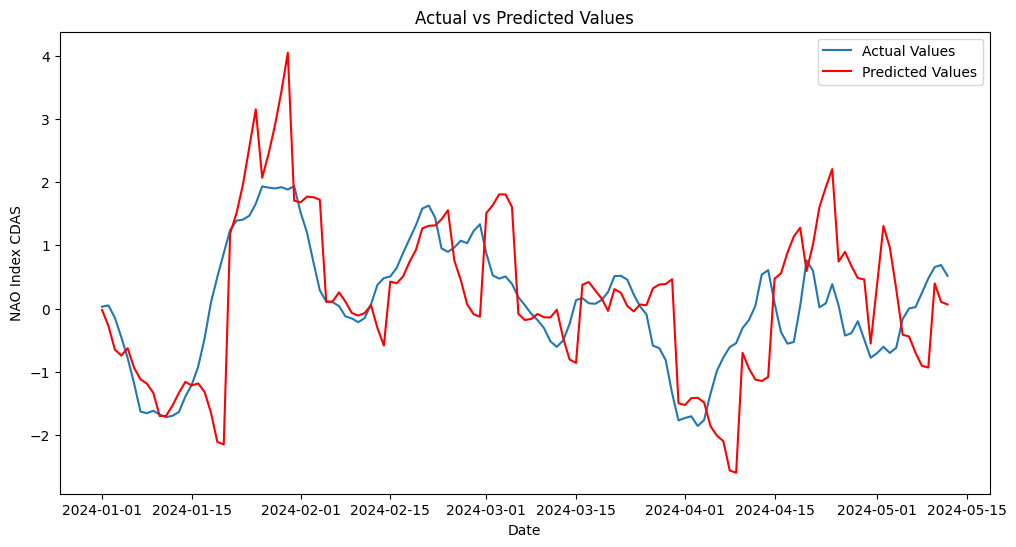

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


predictions = []
history = train['nao_index_cdas'].tolist()

for i in range(0, len(validation), future_points):
    try:
        # Use the last `past_points` from history to fit the model
        model = SARIMAX(history[-past_points:], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12), initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        
        # Make prediction for the next `future_points`
        yhat = model_fit.forecast(steps=future_points)
        predictions.extend(yhat)
        
        # Append the actual values to the history for the next iteration
        next_actuals = validation.iloc[i:i + future_points]['nao_index_cdas'].tolist()
        history.extend(next_actuals)
    except np.linalg.LinAlgError as e:
        print(f"Skipping iteration {i} due to LinAlgError: {e}")
        continue

# Calculate MAE using only the length of validation data
mae = mean_absolute_error(validation['nao_index_cdas'], predictions[:len(validation)])
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(validation.index, validation['nao_index_cdas'], label='Actual Values')
plt.plot(validation.index[:len(predictions)], predictions[:len(validation)], label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NAO Index CDAS')
plt.show()

# LSTM

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout

2024-07-10 17:34:58.954561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 17:34:58.954669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 17:34:59.088580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['nao_index_cdas']])
validation_scaled = scaler.transform(validation[['nao_index_cdas']])



# Prepare the data for LSTM
def create_sequences(data, past_points, future_points):
    X, y = [], []
    for i in range(past_points, len(data) - future_points + 1):
        X.append(data[i - past_points:i, 0])
        y.append(data[i:i + future_points, 0])
    return np.array(X), np.array(y)

past_points = 100
future_points = 5

Epoch 1/3
337/337 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - loss: 0.0612 - val_loss: 0.0124
Epoch 2/3
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - loss: 0.0125 - val_loss: 0.0100
Epoch 3/3
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - loss: 0.0102 - val_loss: 0.0085


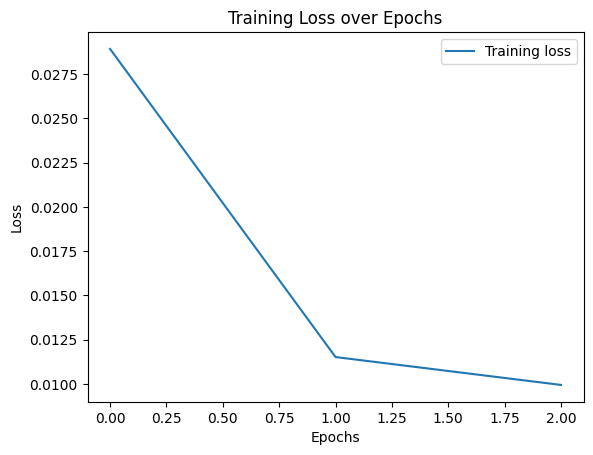

In [13]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(train_scaled, test_size=0.2, shuffle=False)

# Create sequences
X_train, y_train = create_sequences(train_data, past_points, future_points)
X_val, y_val = create_sequences(val_data, past_points, future_points)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build the enhanced Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu')))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(future_points))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64,validation_data=(X_val, y_val), verbose=1)

# Plot the loss values
plt.plot(history.history['loss'], label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 0.4806738262521201


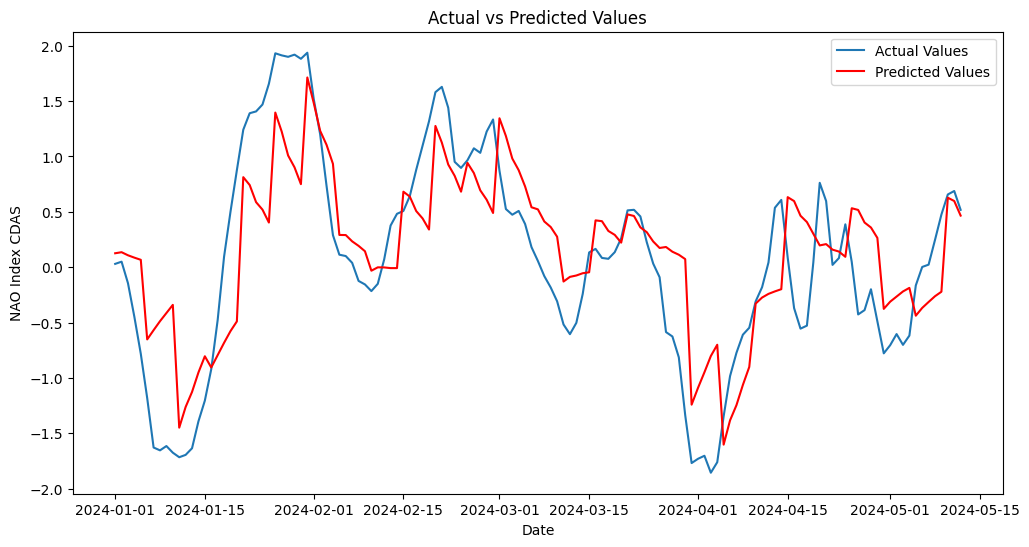

In [14]:
# Make predictions
history = train_scaled.tolist()
predictions = []
for i in range(0, len(validation_scaled), future_points):
    X_input = np.array(history[-past_points:])
    X_input = X_input.reshape((1, past_points, 1))
    yhat = model.predict(X_input, verbose=0)
    predictions.extend(yhat[0].tolist())
    next_actuals = validation_scaled[i:i + future_points].tolist()
    history.extend(next_actuals)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Calculate MAE using only the length of validation data
mae = mean_absolute_error(validation['nao_index_cdas'], predictions[:len(validation)])
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(validation.index, validation['nao_index_cdas'], label='Actual Values')
plt.plot(validation.index[:len(predictions)], predictions[:len(validation)], label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NAO Index CDAS')
plt.show()

# GRU

In [9]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam


In [64]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(train_scaled, test_size=0.2, shuffle=False)

# Create sequences
X_train, y_train = create_sequences(train_data, past_points, future_points)
X_val, y_val = create_sequences(val_data, past_points, future_points)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build the GRU model
model = Sequential()
model.add(GRU(100, activation='relu', return_sequences=True, 
              input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(future_points))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Print the training and validation loss
print(f"Training loss: {history.history['loss'][-1]}")
print(f"Validation loss: {history.history['val_loss'][-1]}")

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 0.0424 - val_loss: 0.0044
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0036 - val_loss: 0.0031
Training loss: 0.003585825441405177
Validation loss: 0.003075619926676154


Mean Absolute Error (MAE): 0.23468482731747792


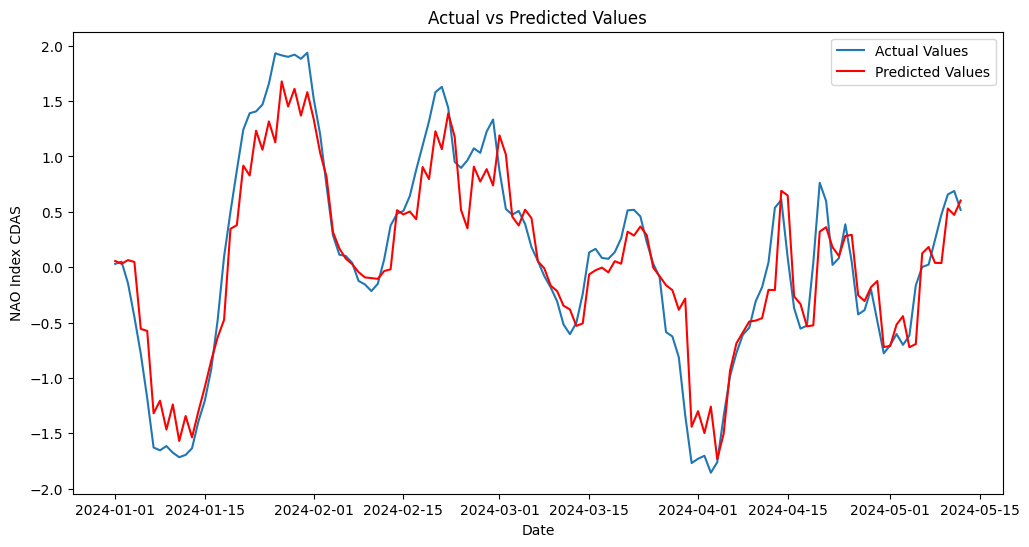

In [65]:
# Make predictions
history = train_scaled.tolist()
predictions = []
for i in range(0, len(validation_scaled), future_points):
    X_input = np.array(history[-past_points:])
    X_input = X_input.reshape((1, past_points, 1))
    yhat = model.predict(X_input, verbose=0)
    predictions.extend(yhat[0].tolist())
    next_actuals = validation_scaled[i:i + future_points].tolist()
    history.extend(next_actuals)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Calculate MAE using only the length of validation data
mae = mean_absolute_error(validation['nao_index_cdas'], predictions[:len(validation)])
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(validation.index, validation['nao_index_cdas'], label='Actual Values')
plt.plot(validation.index[:len(predictions)], predictions[:len(validation)], label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NAO Index CDAS')
plt.show()